In [2]:
import shioaji as sj
import pysimulation

api = sj.Shioaji(simulation=True)
accounts = api.login(
    api_key="",
    secret_key=""
)

2023-06-04 18:54:50.013 | WARNING  | importlib._bootstrap:_call_with_frames_removed:219 - Optional: pip install shioaji[speed] for better performance.


Response Code: 0 | Event Code: 0 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total connection attempt 1 of 1) | Event: Session up


In [ ]:
import datetime
import pandas as pd
from backtesting.lib import OHLCV_AGG

days = 365

# last_days = datetime.datetime.now() - datetime.timedelta(days=days)
last_days = datetime.datetime(2022, 5, 20)

kbars = api.kbars(
    contract=api.Contracts.Futures.TXF.TXFR1, 
    start=last_days.strftime("%Y-%m-%d"), 
    end=last_days.strftime("%Y-%m-%d"),
)

df = pd.DataFrame({**kbars})
df.ts = pd.to_datetime(df.ts)
df = df.set_index('ts')
df.index.name = None
df_1min = df

for i in range(days-1):
    date = last_days + datetime.timedelta(days=i+1)
    print(date.strftime("%Y-%m-%d"))
    kbars = api.kbars(
        contract=api.Contracts.Futures.TXF.TXFR1, 
        start=date.strftime("%Y-%m-%d"), 
        end=date.strftime("%Y-%m-%d"),
    )
    if kbars['ts'] != []:
        df = pd.DataFrame({**kbars})
        df.ts = pd.to_datetime(df.ts)
        df = df.set_index('ts')
        df.index.name = None
        df_1min = pd.concat([df_1min, df], axis=0)

df_1min = df_1min.between_time('00:00:00', '23:59:59')
df_1min = df_1min[['Open', 'High', 'Low', 'Close', 'Volume']]
df_1min.to_csv('TXF_1min.csv')

In [3]:
import datetime
import pandas as pd
import os
from backtesting.lib import OHLCV_AGG

df = pd.read_csv(f"TXF_1min.csv", index_col=0)
df.index = pd.to_datetime(df.index)
df = df.resample('5T', label='right', closed='right').agg(
    {'Open'  :'first',
     'High'  :'max',
     'Low'   :'min',
     'Close' :'last',
     'Volume':'sum'
    })
df.dropna(axis=0, inplace=True)

In [4]:
from backtesting import Strategy
from backtesting.lib import crossover, cross
import talib as ta
from datetime import time, timedelta
import time as t



class myStrategy(Strategy): 
    adx_period = 30
    rsi_period = 12
    overbought = 70
    oversold = 20
    # adx_threshold = 25

    def init(self):
        self.adx30 = self.I(ta.ADX, self.data.High, self.data.Low, self.data.Close, 28)
        self.rsi15 = self.I(ta.RSI, self.data.Close, 13)
        self.adx15 = self.I(ta.ADX, self.data.High, self.data.Low, self.data.Close, 15)
        self.adx20 = self.I(ta.ADX, self.data.High, self.data.Low, self.data.Close, 20)
        self.rsi10 = self.I(ta.RSI, self.data.Close, 5)
        self.slope1 = self.I(ta.LINEARREG_SLOPE, self.data.Close, 12)
        self.slope2 = self.I(ta.LINEARREG_SLOPE, self.rsi10, 12)
    def next(self):
        # operating time : 9:15~13:05, stop loss = 0.4%, take profit = 3%
        if (self.data.index[-1].time() < time(13, 15)) and (self.data.index[-1].time() >= time(9, 15)):
            if self.closed_trades and (self.closed_trades[-1].pl<0) and (self.data.index[-1].to_pydatetime()<(self.closed_trades[-1].exit_time.to_pydatetime()+timedelta(minutes=15))):
                # print(type(self.data.index[-1]))
                pass
            elif (self.rsi15[-1] >= 70) and ((self.adx30[-1] < 15) or crossover(15, self.adx30)) and self.position.is_long:    # pass
                self.position.close()   # pass
                # self.sell(size=200, sl=self.data.Close[-1]*(1+0.007), tp=self.data.Close[-1]*(1-0.025))  # pass
            elif (self.rsi15[-1] <= 20) and ((self.adx30[-1] < 15) or crossover(15, self.adx30)) and self.position.is_short:   # pass
                self.position.close()   # pass
                # self.buy(size=200, sl=self.data.Close[-1]*(1-0.007), tp=self.data.Close[-1]*(1+0.025))  # pass
            elif crossover(70, self.rsi15) and ((self.adx30[-1]>=15) or crossover(self.adx30, 15)) and (not self.position):  # pass
                self.sell(size=200, sl=self.data.Close[-1]*(1+0.005), tp=self.data.Close[-1]*(1-0.03)) # pass
            elif crossover(self.rsi15, 20) and ((self.adx30[-1]>=15) or crossover(self.adx30, 15)) and (not self.position):    # pass
                self.buy(size=200, sl=self.data.Close[-1]*(1-0.005), tp=self.data.Close[-1]*(1+0.03))  # pass
            elif (self.rsi10>40) and self.adx20[-1]>=15 and (self.slope1[-3:]>=0).all() and (self.slope2[-4:]>=0).all():    # pass
                if(not self.position):  # pass
                    self.buy(size=200, sl=self.data.Close[-1]*(1-0.005), tp=self.data.Close[-1]*(1+0.03))  # pass
                elif (self.position.is_short):  # pass
                    self.position.close()   # pass
            elif (self.rsi10<45) and self.adx20[-1]>=15 and (self.slope1[-3:]<=0).all() and (self.slope2[-4:]<=0).all():    # pass
                if (not self.position): # pass
                    self.sell(size=200, sl=self.data.Close[-1]*(1+0.005), tp=self.data.Close[-1]*(1-0.03)) # pass
                elif (self.position.is_long):   # pass
                    self.position.close()   # pass
            elif (self.rsi10>=45) and self.adx20[-1]>=15 and (self.slope1[-3:]<=0).all() and (self.slope2[-4:]>=0).all() and (not self.position):  # pass
                    self.buy(size=200, sl=self.data.Close[-1]*(1-0.005), tp=self.data.Close[-1]*(1+0.03))  # pass
            elif (self.rsi10<=40) and self.adx20[-1]>=15 and (self.slope1[-3:]>=0).all() and (self.slope2[-4:]<=0).all() and (not self.position):  # pass
                    self.sell(size=200, sl=self.data.Close[-1]*(1+0.005), tp=self.data.Close[-1]*(1-0.03)) # ok
            elif (self.data.Close[-4:]>self.data.Open[-4:]).all():
                # if (not self.position) and self.adx15[-1]>=15:
                #     self.buy(size=200, sl=self.data.Close[-1]*(1-0.007), tp=self.data.Close[-1]*(1+0.025))
                if (self.position.is_short):
                    self.position.close()
                    # if self.adx15[-1]>=15:
                    #     self.buy(size=200, sl=self.data.Close[-1]*(1-0.007), tp=self.data.Close[-1]*(1+0.025))
            elif (self.data.Close[-3:]<self.data.Open[-3:]).all():
                # if (not self.position) and self.adx15[-1]>=15:
                #     self.sell(size=200, sl=self.data.Close[-1]*(1+0.007), tp=self.data.Close[-1]*(1-0.025))
                if (self.position.is_long):
                    self.position.close()
                    # if self.adx15[-1]>=15:
                    #     self.sell(size=200, sl=self.data.Close[-1]*(1+0.007), tp=self.data.Close[-1]*(1-0.025))
        elif (self.data.index[-1].time() >= time(13, 25)) and self.position:
            self.position.close()

In [5]:
from backtesting import Backtest

bt = Backtest(df, myStrategy, cash=500_000, commission=0.000033, hedging=False, exclusive_orders=False, margin=0.05)
stats = bt.run()
print(stats)
bt.plot(resample=False)

Start                     2022-05-20 00:00:00
End                       2023-05-20 00:00:00
Duration                    365 days 00:00:00
Exposure Time [%]                   15.987727
Equity Final [$]                  1107932.842
Equity Peak [$]                  1153089.6268
Return [%]                         121.586568
Buy & Hold Return [%]                0.518458
Return (Ann.) [%]                   96.757287
Volatility (Ann.) [%]               59.223969
Sharpe Ratio                         1.633752
Sortino Ratio                        7.300976
Calmar Ratio                        10.528024
Max. Drawdown [%]                   -9.190451
Avg. Drawdown [%]                   -1.261434
Max. Drawdown Duration       61 days 20:25:00
Avg. Drawdown Duration        2 days 05:12:00
# Trades                                  663
Win Rate [%]                        43.740573
Best Trade [%]                        2.95554
Worst Trade [%]                      -0.51748
Avg. Trade [%]                    

Row(id='1880', ...)

In [142]:
print(stats['_trades'].tail(20))

     Size  EntryBar  ExitBar    EntryPrice  ExitPrice         PnL  ReturnPct  \
659   200     53875    53881  15654.516582    15610.0  -8903.3164  -0.002844   
660  -200     53884    53899  15564.486355    15593.0  -5702.7290  -0.001832   
661   200     53902    53905  15592.514536    15570.0  -4502.9072  -0.001444   
662  -200     53909    53925  15553.486718    15526.0   5497.3436   0.001767   
663   200     54133    54140  15511.511863    15535.0   4697.6274   0.001514   
664   200     54144    54147  15555.513315    15542.0  -2702.6630  -0.000869   
665  -200     54150    54153  15533.487378    15528.0   1097.4756   0.000353   
666  -200     54334    54335  15490.488797    15482.0   1697.7594   0.000548   
667   200     54336    54343  15485.511005    15458.0  -5502.2010  -0.001777   
668  -200     54350    54354  15434.490645    15458.0  -4701.8710  -0.001523   
669   200     54559    54605  15611.515163    15703.0  18296.9674   0.005860   
670   200     54787    54793  15748.5196

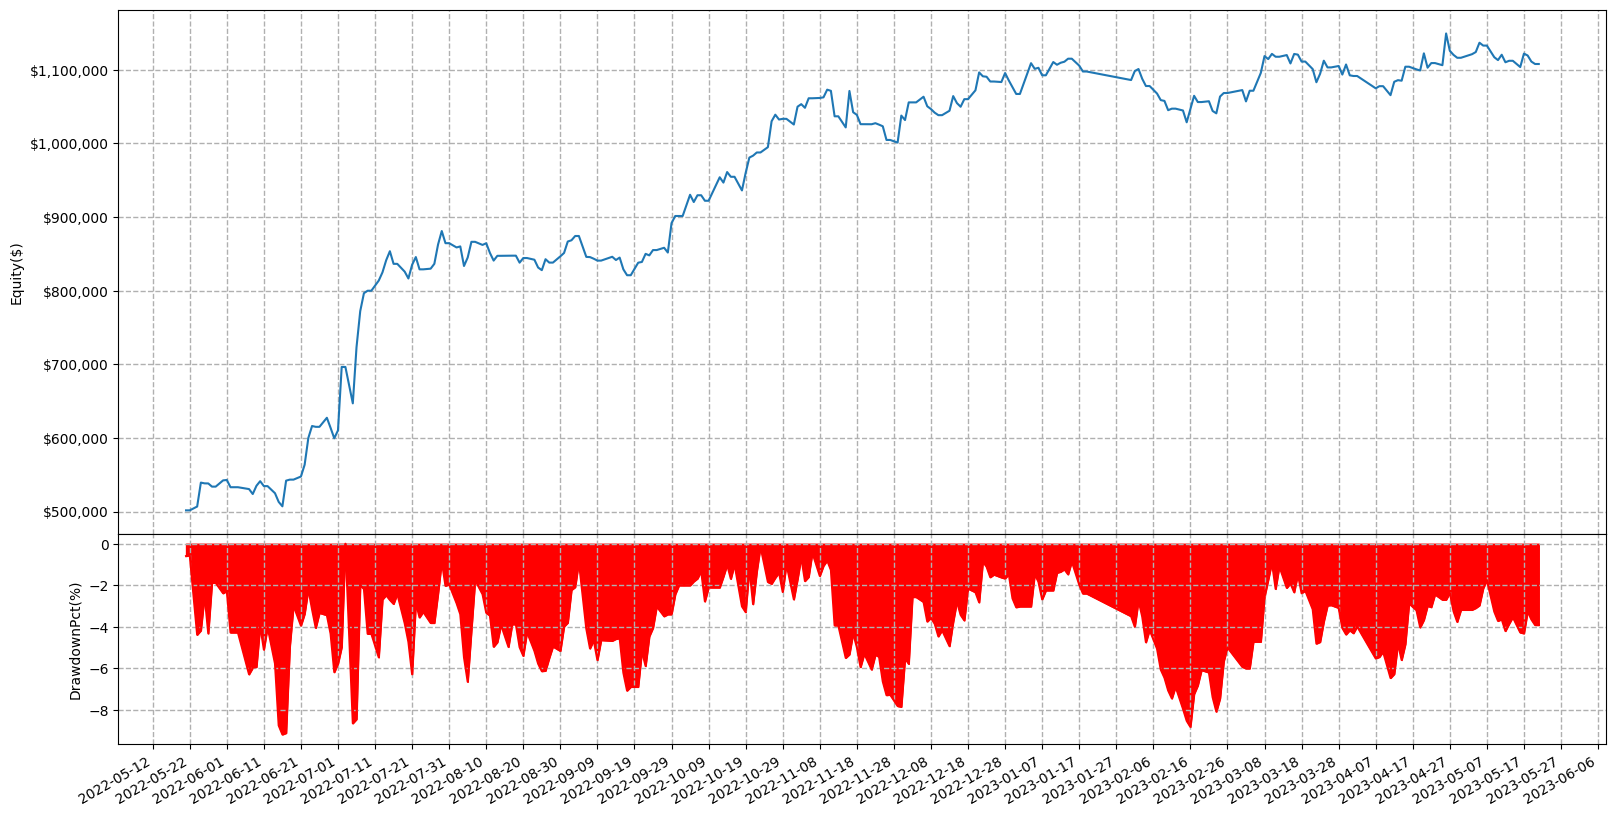

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import StrMethodFormatter
from backtesting.lib import _EQUITY_AGG

equity_data = stats._equity_curve.resample('1D', label='right').agg(_EQUITY_AGG).dropna(how='all')
equity_data['DrawdownPct'] = equity_data['DrawdownPct'].multiply(-100)

f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(19.2, 10.8), gridspec_kw={'height_ratios': [5, 2]})

ax1.grid(linestyle = '--', linewidth = 1)
ax1.plot(equity_data['Equity'])
ax1.set(ylabel="Equity($)")
ax1.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
date_form = DateFormatter("%Y-%m-%d")
ax1.xaxis.set_major_formatter(date_form)
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax2.grid(linestyle = '--', linewidth = 1)
ax2.plot(equity_data['DrawdownPct'], color="red")
ax2.set(ylabel="DrawdownPct(%)")
ax2.fill_between(equity_data['DrawdownPct'].index, equity_data['DrawdownPct'], where=(equity_data['DrawdownPct'] <= 0), color="red")   
f.subplots_adjust(hspace=0)
f.autofmt_xdate()

plt.show()

Start                     2023-01-09 08:50:00
End                       2023-05-20 00:00:00
Duration                    130 days 15:10:00
Exposure Time [%]                   16.047371
Equity Final [$]                  497332.6246
Equity Peak [$]                   542489.4094
Return [%]                          -0.533475
Buy & Hold Return [%]                  9.9631
Return (Ann.) [%]                   -1.352344
Volatility (Ann.) [%]               37.715738
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -19.307257
Avg. Drawdown [%]                   -3.562774
Max. Drawdown Duration       55 days 23:40:00
Avg. Drawdown Duration        8 days 02:21:00
# Trades                                  222
Win Rate [%]                        42.342342
Best Trade [%]                       1.381183
Worst Trade [%]                     -0.516131
Avg. Trade [%]                    

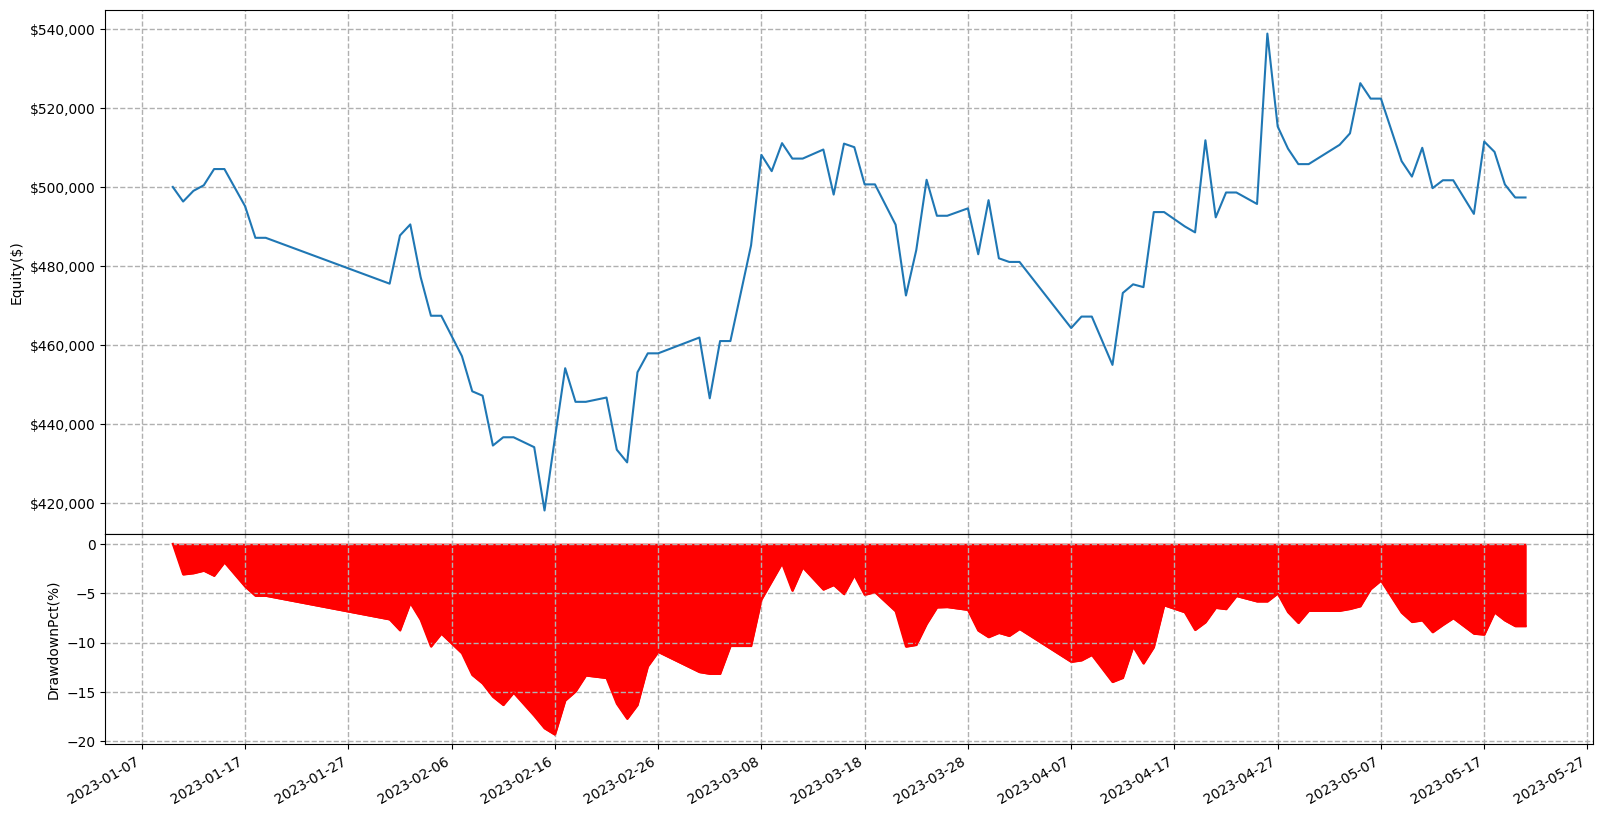

SDK NOTICE Sun May 21 03:37:59.885 2023 solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.50.179:59075'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Sun May 21 03:54:47.479 2023 solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.50.179:53301'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Sun May 21 04:14:25.559 2023 solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.50.179:53483'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Sun May 21 04:31:16.789 2023 solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.50.179:53885'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Sun May 21 04:47:15.880 2023 solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.50.179:54053'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Sun May 21 05:03:51.250 2023 solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.50.179:54252'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Sun May 21 05:19:37.702 2023 solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.50.179:54388'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Sun May 21 05:35:23.861 2023 solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.50.179:54545'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Sun May 21 05:51:19.314 2023 solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.50.179:54705'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Sun May 21 06:07:05.590 2023 solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.50.179:54857'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Sun May 21 06:20:12.093 2023 solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.50.179:55004'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Sun May 21 06:36:01.686 2023 solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.50.179:55138'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Sun May 21 06:51:47.939 2023 solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.50.179:55291'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Sun May 21 07:07:34.184 2023 solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.50.179:55416'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Sun May 21 07:23:20.159 2023 solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.50.179:55583'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Sun May 21 07:39:09.613 2023 solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.50.179:55702'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Sun May 21 07:54:55.820 2023 solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.50.179:55866'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Sun May 21 08:36:31.188 2023 solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.50.179:56004'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Sun May 21 10:38:11.964 2023 solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.50.179:56173'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Sun May 21 11:30:49.280 2023 solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.50.179:56502'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Sun May 21 12:24:59.004 2023 solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.50.179:56672'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Sun May 21 16:24:31.453 2023 solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.50.179:56840'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Sun May 21 17:30:53.920 2023 solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.50.179:63299'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Sun May 21 17:34:09.527 2023 solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.50.179:53391'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Sun May 21 17:38:35.957 2023 solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.50.179:53447'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Sun May 21 17:42:36.459 2023 solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.50.179:53568'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Sun May 21 19:19:16.711 2023 solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.50.179:53638'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Sun May 21 19:43:51.958 2023 solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.50.179:57653'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Sun May 21 20:54:29.717 2023 solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.50.179:59153'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (700003db6000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/R124977781/0520/173625/949061/111.249.139.169', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


In [ ]:
df_out_sample = df[df.index > '2023-1-8']
bt_out = Backtest(df_out_sample, myStrategy, cash=500_000, commission=0.000033, hedging=False, exclusive_orders=False, margin=0.05)
stats_out = bt_out.run()
print(stats_out)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import StrMethodFormatter
from backtesting.lib import _EQUITY_AGG

equity_data = stats_out._equity_curve.resample('1D', label='right').agg(_EQUITY_AGG).dropna(how='all')
equity_data['DrawdownPct'] = equity_data['DrawdownPct'].multiply(-100)

f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(19.2, 10.8), gridspec_kw={'height_ratios': [5, 2]})

ax1.grid(linestyle = '--', linewidth = 1)
ax1.plot(equity_data['Equity'])
ax1.set(ylabel="Equity($)")
ax1.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
date_form = DateFormatter("%Y-%m-%d")
ax1.xaxis.set_major_formatter(date_form)
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax2.grid(linestyle = '--', linewidth = 1)
ax2.plot(equity_data['DrawdownPct'], color="red")
ax2.set(ylabel="DrawdownPct(%)")
ax2.fill_between(equity_data['DrawdownPct'].index, equity_data['DrawdownPct'], where=(equity_data['DrawdownPct'] <= 0), color="red")   
f.subplots_adjust(hspace=0)
f.autofmt_xdate()

plt.show()

In [148]:
from backtesting import Strategy
from backtesting.lib import crossover, cross
import talib as ta
from datetime import time, timedelta
import time as t



class splitStrategy(Strategy): 
    # adx_period = 30
    # rsi_period = 12
    # overbought = 70
    # oversold = 20
    # adx_threshold = 25
    sleepmin = 5

    def init(self):
        self.adx30 = self.I(ta.ADX, self.data.High, self.data.Low, self.data.Close, 28)
        self.rsi15 = self.I(ta.RSI, self.data.Close, 13)
        self.adx15 = self.I(ta.ADX, self.data.High, self.data.Low, self.data.Close, 15)
        self.adx20 = self.I(ta.ADX, self.data.High, self.data.Low, self.data.Close, 20)
        self.rsi10 = self.I(ta.RSI, self.data.Close, 5)
        self.slope1 = self.I(ta.LINEARREG_SLOPE, self.data.Close, 12)
        self.slope2 = self.I(ta.LINEARREG_SLOPE, self.rsi10, 12)
    def next(self):
        # operating time : 9:15~13:05, stop loss = 0.4%, take profit = 3%
        if (self.data.index[-1].time() < time(13, 15)) and (self.data.index[-1].time() >= time(9, 15)):
            if self.closed_trades and (self.closed_trades[-1].pl<0) and (self.data.index[-1].to_pydatetime()<(self.closed_trades[-1].exit_time.to_pydatetime()+timedelta(minutes=int(self.sleepmin)))):
                # print(type(self.data.index[-1]))
                pass
            elif (self.rsi15 >= 70) and ((self.adx30[-1] < 15) or crossover(15, self.adx30)) and self.position.is_long:    # pass
                self.position.close()   # pass
                # self.sell(size=200, sl=self.data.Close[-1]*(1+0.007), tp=self.data.Close[-1]*(1-0.025))  # pass
            elif (self.rsi15 <= 20) and ((self.adx30[-1] < 15) or crossover(15, self.adx30)) and self.position.is_short:   # pass
                self.position.close()   # pass
                # self.buy(size=200, sl=self.data.Close[-1]*(1-0.007), tp=self.data.Close[-1]*(1+0.025))  # pass
            elif crossover(70, self.rsi15) and ((self.adx30[-1]>=15) or crossover(self.adx30, 15)) and (not self.position):  # pass
                self.sell(size=200, sl=self.data.Close[-1]*(1+0.005), tp=self.data.Close[-1]*(1-0.03)) # pass
            elif crossover(self.rsi15, 20) and ((self.adx30[-1]>=15) or crossover(self.adx30, 15)) and (not self.position):    # pass
                self.buy(size=200, sl=self.data.Close[-1]*(1-0.005), tp=self.data.Close[-1]*(1+0.03))  # pass
            elif (self.rsi10>40) and self.adx20[-1]>=15 and (self.slope1[-3:]>=0).all() and (self.slope2[-4:]>=0).all():    # pass
                if(not self.position):  # pass
                    self.buy(size=200, sl=self.data.Close[-1]*(1-0.005), tp=self.data.Close[-1]*(1+0.03))  # pass
                elif (self.position.is_short):  # pass
                    self.position.close()   # pass
            elif (self.rsi10<45) and self.adx20[-1]>=15 and (self.slope1[-3:]<=0).all() and (self.slope2[-4:]<=0).all():    # pass
                if (not self.position): # pass
                    self.sell(size=200, sl=self.data.Close[-1]*(1+0.005), tp=self.data.Close[-1]*(1-0.03)) # pass
                elif (self.position.is_long):   # pass
                    self.position.close()   # pass
            elif (self.rsi10>=45) and self.adx20[-1]>=15 and (self.slope1[-3:]<=0).all() and (self.slope2[-4:]>=0).all() and (not self.position):  # pass
                    self.buy(size=200, sl=self.data.Close[-1]*(1-0.005), tp=self.data.Close[-1]*(1+0.03))  # pass
            elif (self.rsi10<=40) and self.adx20[-1]>=15 and (self.slope1[-3:]>=0).all() and (self.slope2[-4:]<=0).all() and (not self.position):  # pass
                    self.sell(size=200, sl=self.data.Close[-1]*(1+0.005), tp=self.data.Close[-1]*(1-0.03)) # ok
            elif (self.data.Close[-4:]>self.data.Open[-4:]).all():
                # if (not self.position) and self.adx15[-1]>=15:
                #     self.buy(size=200, sl=self.data.Close[-1]*(1-0.007), tp=self.data.Close[-1]*(1+0.025))
                if (self.position.is_short):
                    self.position.close()
                    # if self.adx15[-1]>=15:
                    #     self.buy(size=200, sl=self.data.Close[-1]*(1-0.007), tp=self.data.Close[-1]*(1+0.025))
            elif (self.data.Close[-3:]<self.data.Open[-3:]).all():
                # if (not self.position) and self.adx15[-1]>=15:
                #     self.sell(size=200, sl=self.data.Close[-1]*(1+0.007), tp=self.data.Close[-1]*(1-0.025))
                if (self.position.is_long):
                    self.position.close()
                    # if self.adx15[-1]>=15:
                    #     self.sell(size=200, sl=self.data.Close[-1]*(1+0.007), tp=self.data.Close[-1]*(1-0.025))
        elif (self.data.index[-1].time() >= time(13, 25)) and self.position:
            self.position.close()

In [149]:
from backtesting import Backtest
import numpy as np
df_in_sample = df[df.index <= '2023-1-8']
bt = Backtest(df_in_sample, splitStrategy, cash=500_000, commission=0.000033, hedging=False, exclusive_orders=False, margin=0.05)
stats = bt.optimize(
                    # adx30_period = range(25,29,1),
                    # adx20_period = range(19,21,1),
                    # adx15_period = range(14,16,1),
                    # rsi15_period = range(10,14,1),
                    # rsi10_period = range(5,9,1),
                    # slope_period = range(5,15,1),
                    # adx_threshold  = range(10,35,1),
                    # loss = [0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008],
                    # profit = [0.02, 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027, 0.028, 0.029, 0.03],
                    sleepmin = [5, 10, 15, 20, 25, 30],
                    maximize='Equity Final [$]',
                    # constraint=lambda p: p.low < p.high
                    )
print(stats.to_string())

Backtest.optimize:   0%|          | 0/6 [00:00<?, ?it/s]

Start                                                   2022-05-20 00:00:00
End                                                     2023-01-07 05:00:00
Duration                                                  232 days 05:00:00
Exposure Time [%]                                                  15.85534
Equity Final [$]                                               1092593.5974
Equity Peak [$]                                                1117748.4526
Return [%]                                                       118.518719
Buy & Hold Return [%]                                             -8.882504
Return (Ann.) [%]                                                172.026468
Volatility (Ann.) [%]                                             95.346568
Sharpe Ratio                                                       1.804223
Sortino Ratio                                                     11.756799
Calmar Ratio                                                      18.717958
Max. Drawdow

In [ ]:
print(stats.order)